# Haar like features
Haar-like features are digital image features used in object recognition.

![img/haarExample.png](img/haarExample.png)

Each feature is computed by integrating the gray scale image.
The sum of the pixels which lie within the white rectangles are subtracted from the sum of pixels in the grey rectangles.

Viola jones uses 5 types of features:
 - Two rectangle feature, vertical (feature A).
 - Two rectangle feature, horizontal (feature B).
 - Three rectangle feature, horizontal (feature C).
 - Three rectangle feature, vertical (similar to feature C, except it is vertical).
 - Four rectangle feature, (feature D).
 
Each feature can have different size and location within the detection window. The detection window has a size of 24x24 pixels which gives a total number of 180,000 possible features.

Let's compute the example feature.
First we have to load the image and scale it down.

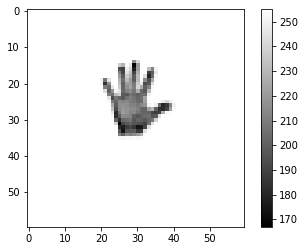

In [1]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('testImage.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (60, 60), interpolation = cv2.INTER_AREA)

plt.imshow(img ,cmap='gray')
plt.colorbar()
plt.show()

Then let's extract the detection window.

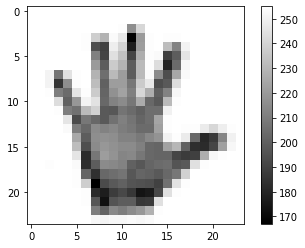

In [2]:
import numpy as np

def cropImage(img, x, y, width, height):
    return np.array(img[y:y+height, x:x+width])

pos = (18, 12)
size = (24, 24)
cropImg = cropImage(img, pos[0], pos[1], size[0], size[1])

plt.imshow(cropImg ,cmap='gray')
plt.colorbar()
plt.show()

Now let's generate example Haar feature.

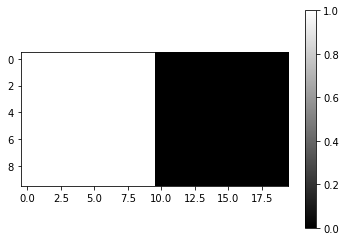

In [3]:
import numpy as np

def genHaarMagic(size):
    haar = np.ones(size)
    for x in range(0, size[0]):
        for y in range(int(size[1]/2), size[1]):
            haar[x][y] = 0
            
    return haar

haar = genHaarMagic((10, 20))
plt.imshow(haar ,cmap='gray')
plt.colorbar()
plt.show()

Now let's apply the Haar feature. In order to do this we can crop the detection window and then treat the haar feature as a mask.

In [4]:
size = (haar.shape[1], haar.shape[0]) # rows and then columns DOUH!
areaUnderHaar = cropImage(cropImg, 2, 9, size[0], size[1])

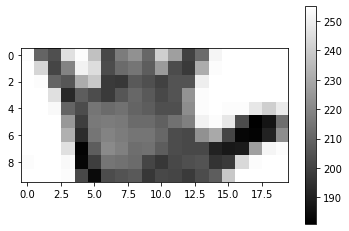

In [5]:
plt.imshow(areaUnderHaar, cmap='gray')
plt.colorbar()
plt.show()

Then compute the integral (sum of all pixels).

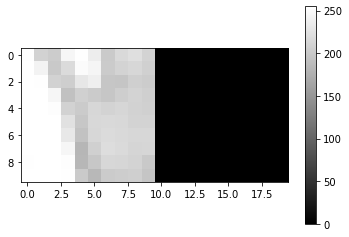

In [6]:
maskedImage = areaUnderHaar*(haar==1)

plt.imshow(maskedImage, cmap='gray')
plt.colorbar()
plt.show()

In [7]:
whiteInt = np.sum(maskedImage)
print(whiteInt)

22387


Then we have to repeat the process for the area under black rectangle.

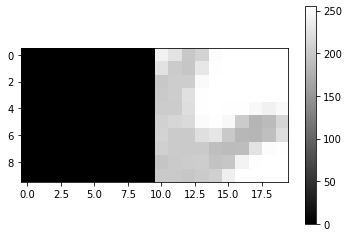

In [8]:
maskedImage = areaUnderHaar*(haar == 0)

plt.imshow(maskedImage, cmap='gray')
plt.colorbar()
plt.show()

In [9]:
darkInt = np.sum(maskedImage)
print(darkInt)

22807


And finally we can compute the value of our Haar feature.

In [10]:
haarValue = int(whiteInt) - int(darkInt)
print(haarValue)

-420


# Integral image
The above method is incredibly inefficient.
To speed up the computation of the integral we can use so called integral image.
Integral image is an image defined using a formula:

$$ I(x,y) = \sum_{x' \leq x \\ y' \leq y}^{} i(x', y')$$
Where I(x,y) is an integral image function and i(x, y) is an image function.

Integral image can be computed using the following formula.
$$ I(x,y) = i(x,y) + I(x, y-1) + I(x-1, y) - I(x-1, y-1) $$

Example:

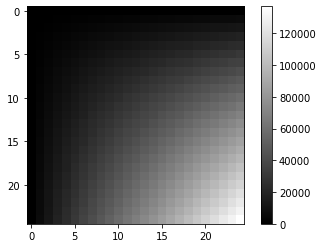

In [11]:
integralImage = cv2.integral(cropImg)

plt.imshow(integralImage, cmap='gray')
plt.colorbar()
plt.show()

We can use integral image to very quickly compute the integral over the rectangular region.

![img/integralImageUsage.png](img/integralImageUsage.png)

The value of the integral image at location 1 is the sum of the pixels in rectangle A. The value at locations 2 is A+B at location 3 is A+C and at location 4 is A+B+C+D. The sum within D can be computed as 4+1-(2+3).


# Computing Haar like features using integral image

Now let's compute the same Haar feature using integral image.
First we have to define a function that takes the integral image and computes the sum of a rectangular region.

In [12]:
def sum_region(integral_img_arr, top_left, bottom_right):
    """
    Calculates the sum in the rectangle specified by the given tuples.
    :param integral_img_arr:
    :type integral_img_arr: numpy.ndarray
    :param top_left: (x, y) of the rectangle's top left corner
    :type top_left: (int, int)
    :param bottom_right: (x, y) of the rectangle's bottom right corner
    :type bottom_right: (int, int)
    :return The sum of all pixels in the given rectangle
    :rtype int
    """
    top_left = (top_left[1], top_left[0])
    bottom_right = (bottom_right[1], bottom_right[0])
    
    if top_left == bottom_right:
        return integral_img_arr[top_left]
    
    top_right = (bottom_right[0], top_left[1])
    bottom_left = (top_left[0], bottom_right[1])
    return integral_img_arr[bottom_right] - integral_img_arr[top_right] - integral_img_arr[bottom_left] + integral_img_arr[top_left]

Now let's define the location and size of the feature.

In [13]:
position = (2, 9)
width = 20
height = 10

#define corners
top_left = position
bottom_right = (position[0] + width, position[1] + height)

And then compute the value of the feature.

In [14]:

first = sum_region(integralImage, top_left, (int(top_left[0] + width / 2), top_left[1] + height))
second = sum_region(integralImage, (int(top_left[0] + width / 2), top_left[1]), bottom_right)
score = first - second

print("Score is: " + str(score))

Score is: -420


As we can see the score is exactly the same as from the naive method.

# Hand image dataset

In order to train and build a classifier we will need two datasets. Training dataset for training a classifier and test dataset for evaluating performance. Datasets should contain a number of detection windows containing hands and a number of detection windows that do not contain hands. We will be using supervised learning so each sample must have a label indicating whether it contains hand or not. Each dataset contains a number of detection frames containing hands (positive samples), and background pictures (negative samples).

For our example we used this dataset: https://www.ece.nus.edu.sg/stfpage/elepv/NUS-HandSet//?fbclid=IwAR2YhmdFXKnWpO2BmJ2-u_qXv_rIgIhF3O8tiy58XVBbdLWntFWh_BfKAP4

And manually prepared 200 samples by cutting out the square region containing hand.
To simplify we decided to consider only one pose. 

First thing that we have to do is to load the dataset as an array of images.
Dataset is attached to the repository in a form of the compressed tarball so we have to uncompress it first.

In [15]:
import tarfile
import os

DATASET_FILE = "dataset.tar.gz"
DATASET_DIR = "dataset"

#if directory dataset exists, skip decompressing
if os.path.isdir(DATASET_DIR):
    print("Dataset already exists! Skipping dataset decompression!")
else:
    with tarfile.open(DATASET_FILE) as tar:
        print("Decompressing dataset...")
        tar.extractall()
        print("Done!")
    

Dataset already exists! Skipping dataset decompression!


Dataset consists out of two directories.
Positive contains positive samples. Negative contains negative samples.
Now we have to load all images from those directories.
Since the dataset is quite small in size we can just load it into the system memory.

In [16]:
from os import listdir
from os.path import isfile, join

def load_all_from_dir(dir):
    files = [f for f in listdir(dir) if isfile(join(dir, f))]
    images = []
    for path in files:
        img = cv2.imread(dir+"/"+str(path))
        
        #convert color to rgb so matplotlib does not show false colors
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        images.append(img)
    return images

positiveSamples = load_all_from_dir(DATASET_DIR+"/positive")
negativeSamples = load_all_from_dir(DATASET_DIR+"/negative")

Let's take a quick look at the samples.

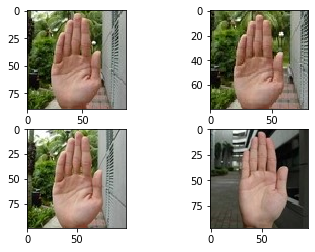

In [17]:
fig,a =  plt.subplots(2,2)
a[0][0].imshow(positiveSamples[0])
a[0][1].imshow(positiveSamples[1])
a[1][0].imshow(positiveSamples[2])
a[1][1].imshow(positiveSamples[3])

plt.show()

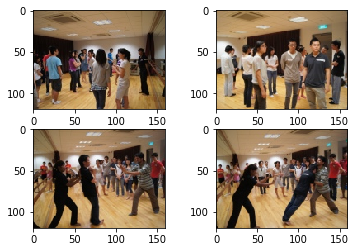

In [18]:
fig,a =  plt.subplots(2,2)
a[0][0].imshow(negativeSamples[0])
a[0][1].imshow(negativeSamples[1])
a[1][0].imshow(negativeSamples[2])
a[1][1].imshow(negativeSamples[3])

plt.show()

# Preparing dataset for training

First thing that we need to do is to convert all images to grayscale and resize all hand images to the size of the detection frame.

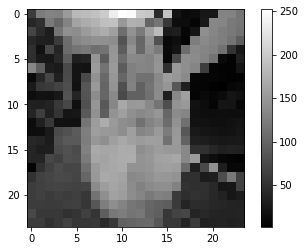

In [19]:
def scale_images(images, width, height):
    processedImages = []
    for img in images:
        processedImages.append(cv2.resize(img, (width, height)))
    
    return np.array(processedImages)

def convert_to_grayScale(images):
    processedImages = []
    for img in images:
        processedImages.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    
    return np.array(processedImages)

positiveSamples = scale_images(positiveSamples, 24, 24)
positiveSamples = convert_to_grayScale(positiveSamples)
negativeSamples = convert_to_grayScale(negativeSamples)

plt.imshow(positiveSamples[4], cmap='gray')
plt.colorbar()
plt.show()

Then we have to choose a number of random detection frames from the negative samples dataset. We will have twice as many negative samples as positive samples. We have 200 negative samples so we will choose 2 frames from each image.

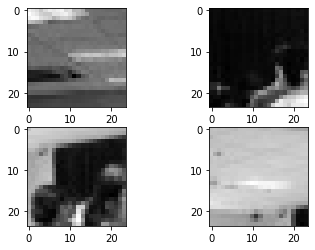

In [20]:
import random

#seed Pseudo Random Number Generator (PRNG)
#constant seed is used to ensure that results are exactly the same on each run
random.seed(42)

def random_crop(img, x, y, width, height):
    x = random.randint(x[0], x[1])
    y = random.randint(y[0], y[1])
    return cropImage(img, x, y, width, height)

negativeDetectionFrames = []

for img in negativeSamples:
    negativeDetectionFrames.append(random_crop(img, (0, img.shape[1]-42), (0, img.shape[0]-42), 24, 24))
    negativeDetectionFrames.append(random_crop(img, (0, img.shape[1]-42), (0, img.shape[0]-42), 24, 24))

negativeSamples = negativeDetectionFrames
del negativeDetectionFrames

fig,a =  plt.subplots(2,2)
a[0][0].imshow(negativeSamples[0], cmap='gray')
a[0][1].imshow(negativeSamples[1], cmap='gray')
a[1][0].imshow(negativeSamples[2], cmap='gray')
a[1][1].imshow(negativeSamples[3], cmap='gray')

plt.show()

Then we have to perform a split to training and testing dataset. The standard proportions are 2/3 for training and 1/3 for testing. In order to do this we will perform random sampling by randomly shuffling the array and then taking top 1/3 samples as test dataset. For smaller datasets it would be better to perform stratified sampling but for this demonstration random sapling is also acceptable.


In [21]:
random.shuffle(positiveSamples)
random.shuffle(negativeSamples)

positive_train = positiveSamples[len(positiveSamples)//3:]
negative_train = negativeSamples[len(negativeSamples)//3:]

positive_test = positiveSamples[:len(positiveSamples)//3]
negative_test = negativeSamples[:len(negativeSamples)//3]

print("Training dataset: " + str(len(positive_train)) + " positive samples, " + str(len(negative_train)) + " negative samples")
print("Test dataset: " + str(len(positive_test)) + " positive samples, " + str(len(negative_test)) + " negative samples")

Training dataset: 134 positive samples, 267 negative samples
Test dataset: 66 positive samples, 133 negative samples


The last thing that we have to do is to perform the variance normalization to negate the effects of different lighitng. The same normalization will be necessary later during classifier run.
Variance normalization is performed by substracting mean value and dividing by standard deviation. We will also convert the image pixels to floating point numbers from the range <0, 1> to avoid problems with integer division.

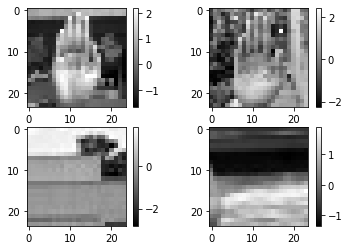

In [22]:
def normalize(images):
    normalized = []
    for img in images:
        img = img.astype(np.float32) / 255
        img -= img.mean()
        img /= img.std()
        normalized.append(img)
    return normalized

positive_train = normalize(positive_train)
negative_train = normalize(negative_train)

positive_test = normalize(positive_test)
negative_test = normalize(negative_test)

fig,a =  plt.subplots(2,2)
plot1 = a[0][0].imshow(positive_train[0], cmap='gray')
fig.colorbar(plot1, ax=a[0][0])
plot2 = a[0][1].imshow(positive_train[1], cmap='gray')
fig.colorbar(plot2, ax=a[0][1])
plot3 = a[1][0].imshow(negative_train[0], cmap='gray')
fig.colorbar(plot3, ax=a[1][0])
plot4 = a[1][1].imshow(negative_train[1], cmap='gray')
fig.colorbar(plot4, ax=a[1][1])
plt.show()

# Building a weak classifier
Now we have to build a classifier using haar like featues. The classifier shall compute the value of the feature and use it to determine whether the detecion window contains hand or not. Of course a single feature is not a reliable indicator of the hand presence. For this reason we will call this classifier weak.

$$
h_j(x) = 
\begin{array}{cc}
  \Bigg\{ & 
    \begin{array}{cc}
      1 & \text{if } p_j f_j(x) < p_j 	\theta_j\\
      0 & \text{otherwise}
    \end{array}
\end{array}
$$

A weak classifier h(x) consists of a featuyre f(x), a  threshold thetha and a parity p indicating the direction of the inequality sign.

To build such classifier first we have to define the Haar feature class.

In [23]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]

class Haar():
    """
    :param haarType: Type of the haar feature.
    :param position: Position of the feature (x,y) inside the detection window.
    :param width: Width of the haar feature.
    :param height: Height of the haar feature.
    """
    def __init__(self, haarType, position, width, height):
        self.type = haarType
        
        #corners
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        
        #sizes
        self.width = width
        self.height = height

        """
        :param int_img: Integral image
        :param x: Position of the detection frame (X)
        :param y: Position of the detection frame (Y)
        """
    def computeScore(self, int_img, x, y):
        score = 0
        
        #compute new corners to account for the position of the detection frame
        top_left = (self.top_left[0] + x, self.top_left[1] + y)
        bottom_right = (self.bottom_right[0] + x, self.bottom_right[1] + y)
        
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, top_left, (top_left[0] + self.width, int(top_left[1] + self.height / 2)))
            second = sum_region(int_img, (top_left[0], int(top_left[1] + self.height / 2)), bottom_right)
            score = first - second
            
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, top_left, (int(top_left[0] + self.width / 2), top_left[1] + self.height))
            second = sum_region(int_img, (int(top_left[0] + self.width / 2), top_left[1]), bottom_right)
            score = first - second
            
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, top_left, (int(top_left[0] + self.width / 3), top_left[1] + self.height))
            second = sum_region(int_img, (int(top_left[0] + self.width / 3), top_left[1]), (int(top_left[0] + 2 * self.width / 3), top_left[1] + self.height))
            third = sum_region(int_img, (int(top_left[0] + 2 * self.width / 3), top_left[1]), bottom_right)
            score = first - second + third
            
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, top_left, (bottom_right[0], int(top_left[1] + self.height / 3)))
            second = sum_region(int_img, (top_left[0], int(top_left[1] + self.height / 3)), (bottom_right[0], int(top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (top_left[0], int(top_left[1] + 2 * self.height / 3)), bottom_right)
            score = first - second + third
            
        elif self.type == FeatureType.FOUR:
            first = sum_region(int_img, top_left, (int(top_left[0] + self.width / 2), int(top_left[1] + self.height / 2)))
            second = sum_region(int_img, (int(top_left[0] + self.width / 2), top_left[1]), (bottom_right[0], int(top_left[1] + self.height / 2)))
            third = sum_region(int_img, (top_left[0], int(top_left[1] + self.height / 2)), (int(top_left[0] + self.width / 2), bottom_right[1]))
            fourth = sum_region(int_img, (int(top_left[0] + self.width / 2), int(top_left[1] + self.height / 2)), bottom_right)
            score = first - second - third + fourth
            
        return score


Then we have to define the weak classifier class.

In [24]:
class WeakClassifier():
    """
    :param haarFeature: Feature
    :param threshold: Threshold value
    :param polarity: Polarity
    """
    def __init__(self, haarFeature, threshold, polarity):
        self.feature = haarFeature
        self.threshold = threshold
        self.polarity = polarity
    
    """
    :param int_image: Integral image
    :param x: Position of the detection frame (X)
    :param y: Position of the detection frame (Y)
    """
    def classify(self, int_image, x, y):
        return self.polarity*self.feature.computeScore(int_image, x, y) < self.polarity*self.threshold


Now let's compute the value of the feature for example positive sample and compare it to the value for the negative sample.

In [25]:
intImage_positive = cv2.integral(positive_train[0])
intImage_negative = cv2.integral(negative_train[0])
awesomeHaar = Haar(FeatureType.TWO_HORIZONTAL, (2, 9), 20, 10)

print("Positive core is : " + str(awesomeHaar.computeScore(intImage_positive, 0, 0)))
print("Negative core is : " + str(awesomeHaar.computeScore(intImage_negative, 0, 0)))

Positive core is : 10.55382614582777
Negative core is : 38.08548865187913


Now let's setup the weak classifier and test it.

In [26]:
classifier = WeakClassifier(awesomeHaar, 20, 1)
print("Positive sample score: " + str(classifier.classify(intImage_positive, 0, 0)))
print("Negative sample score: " + str(classifier.classify(intImage_negative, 0, 0)))

Positive sample score: True
Negative sample score: False
